# ProfHMM Notebook Tutorial 2023:  PART 2 / ProfHMM prediction

In [1]:
from submapp import *
from tools.preprocessing.preprocessor import normalization
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml as yml
plt.rcParams['figure.figsize'] = [16, 12] # size of figure
from tools.tools_som import print_data_ax

# 1) Specify object paths and load informations
We will use objects that you saved during "Profhmm_training" tutorial. For this specify the name of the experiment if you used default paths.

#### TO DO : 
* <font color=red>Specify the same experiment name that you have chosen for the training tutorial.</font>

In [31]:
name_of_experiment= "test2"

# Paths to objects
path_hmm = "./objects/{}/Hmm/hmm".format(name_of_experiment)
path_som_surf = "./objects/{}/Som/surf".format(name_of_experiment)
path_som_prof = "./objects/{}/Som/prof".format(name_of_experiment)

# Path to the surface dataset that we will use to infer vertical profile
path_surface_data = "./data/infer_surf.npy"
path_surface_yaml = "./data/info_surf_prediction.yml"

In [32]:
# Load HMM, SOM and observation to infer
myHmm= hmm.load(filename=path_hmm)
Som_surf= som.load(filename=path_som_surf)
Som_prof= som.load(filename=path_som_prof)

# Load surface observation np.array to infer subsurface
infer_surf_data = np.load(path_surface_data, allow_pickle=True)
meas_per_block = np.shape(infer_surf_data[0,0])[0]

In [33]:
print(np.shape(infer_surf_data))
print(np.shape(infer_surf_data[0,0])[0])

(4, 3)
73


In [34]:
# Load the data descriptor associated to the np.array
def yaml_loader(path):
    """ Little function to load yaml file information in a dictionnary."""
    try:
        with open(path, "r") as file:
            dic = yml.safe_load(file)
            file.close()
    except Exception as e:
        print("Error reading the information yaml file")
    return dic

info_surf=yaml_loader(path_surface_yaml)
surf_var = info_surf["variables"]
surf_units = info_surf["unit"]
blocks = info_surf["blocks"]
nb_blocks=len(blocks)

# 2) Prepare observations to infer
We still need to normalize data, as it was the case during the training process, and for this we use standard deviation and mean determined during the training. After that, we can use the trained surface SOM to classify this new dataset.

In [35]:
# normalization
infer_surf_norm = normalization(nb_blocks, infer_surf_data, len(surf_var), new_data=True, data_stdev=Som_surf.data_stdev, data_mean=Som_surf.data_mean)

if nb_blocks > 1:
    infer_surf_norm = np.concatenate(infer_surf_norm).astype('float64')

In [36]:
print(np.shape(infer_surf_norm))
print(infer_surf_norm)

(219, 4)
[[-1.26589086e+00 -6.75297266e-01 -1.09922242e+00  6.75312484e-01]
 [-1.26955732e+00 -7.24736617e-01 -1.09959090e+00  6.90112046e-01]
 [-1.26892733e+00 -7.68951486e-01 -1.08653401e+00  7.00591311e-01]
 [-1.27290623e+00 -8.14024451e-01 -1.08053824e+00  1.04400092e+00]
 [-1.26921573e+00 -8.25281877e-01 -1.06855856e+00  7.84542387e-01]
 [-1.25327440e+00 -8.21333435e-01 -1.05537936e+00 -1.03275695e-01]
 [-1.24480337e+00 -8.31362525e-01 -1.03268268e+00  3.70520629e-01]
 [-1.22576939e+00 -8.36191082e-01 -9.30097843e-01  7.35311299e-01]
 [-1.25218222e+00 -8.60880242e-01 -9.24133678e-01  1.28877484e+00]
 [-1.25143022e+00 -8.68044954e-01 -9.54716148e-01  1.23382965e+00]
 [-1.26156938e+00 -9.09474436e-01 -8.13402594e-01  1.33181535e+00]
 [-1.26501271e+00 -9.43244396e-01 -6.52394833e-01  1.70592238e+00]
 [-1.23364157e+00 -9.60193497e-01 -4.89455936e-01  1.78727105e+00]
 [-1.16329702e+00 -9.71852449e-01 -3.80469260e-01  1.40384988e+00]
 [-9.36304264e-01 -9.56132843e-01 -3.63401045e-01  2.

In [37]:
# classification
map_infer_surf = map2d.Map2d(som=Som_surf, name='map_obs_infer')
map_infer_surf.map_from_data(infer_surf_norm, overwrite=True)

# 3) Prediction step
We apply the Viterbi algorithm to get which class is inferred for each surface input vector. Then, we get the corresponding referent vector.

In [38]:
# Apply Virterbi alogirhtm to get a prediction.
classes_estimated = myHmm.viterbi(map_infer_surf.classes)

# Construct a map based on the profile SOM already trained and classes given by Viterbi algorithm.
map_estimated = map2d.Map2d(som=Som_prof, name="map_estimation")
map_estimated.map_from_classes(classes_estimated, overwrite=True)

Viterbi algorithm done in  0.1  sec, using  219  inputs


In [39]:
# Save all outputs vertical profile of prediction step in one numpy array
path_estimated_profile = "./objects/{}/estimated_prof.npy".format(name_of_experiment)
np.save(path_estimated_profile ,map_estimated.values, allow_pickle=True) # we access to vertical profile with .values

# 4) Compare to truth
As we are in a tutorial, we have the true vertical profile corresponding to the surface dataset to infer. So we can compare, truth and prediction results.

Of course in reality, this step is not possible as we did a real prediction with unknown vertical profile.

In [40]:
# Load true verticale profile
path_truth_data_profile = "./data/truth_prof.npy"
path_truth_yaml_profile = "./data/info_prof_prediction.yml"
true_prof_data = np.load(path_truth_data_profile, allow_pickle=True)


info_prof = yaml_loader(path_truth_yaml_profile)
depth_levels = info_prof["depth"]
prof_var = info_prof["variables"]
prof_units = info_prof["unit"]

# normalization
true_prof_norm = normalization(nb_blocks, true_prof_data, len(prof_var), new_data=True, data_stdev=Som_prof.data_stdev, data_mean=Som_prof.data_mean)
if nb_blocks > 1:
    true_prof_norm = np.concatenate(true_prof_norm).astype('float64')
    
# classification
map_expected = map2d.Map2d(som=Som_prof, name="map_expected")
map_expected.map_from_data(true_prof_norm)

# add true values to the maps estimated true values
if nb_blocks>1:
    map_estimated.add_true_values(np.concatenate(true_prof_data[0,:]))
else :
    map_estimated.add_true_values(true_prof_data[0,0])                            

# 5) Save your maps

In [41]:
path_map_saving = "./objects/{}/Map/".format(name_of_experiment)
path_fig_saving = "./figs/{}/".format(name_of_experiment)
os.makedirs(path_map_saving, exist_ok=True)
os.makedirs(path_fig_saving, exist_ok=True)

map2d.save(map_estimated, filename=path_map_saving+"map_estimated")
map2d.save(map_expected, filename=path_map_saving+"map_expected")
del(map_estimated)
del(map_expected)

# 6) Compare expected, estimated and true values
The expected values are the best that we can retrieve with the HMM.

So you can reload the obejcts Map with map2d package and then :
- Access to estimated values, with the map you have created : **map_estimated.values** and then the true values were stored, so you can access with : **map_estimated.true_values**

- Acces to expected values (mapped from truth): **map_expected.values**

In [42]:
# This is how you reload your map to analyze results.
map_estimated = map2d.load(filename=path_map_saving+"map_estimated")
map_expected = map2d.load(filename=path_map_saving+"map_expected")

## 6.1) Estimated vs expected and true values

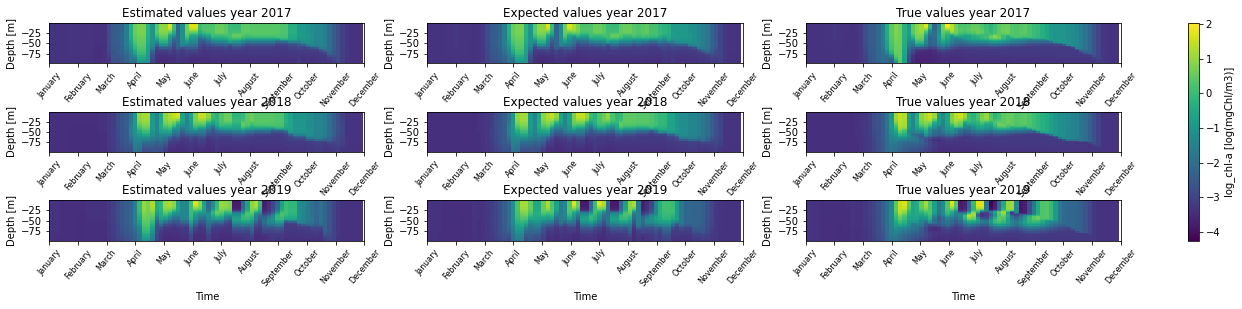

In [43]:
# This plot is specific to the tutorial, it may not work for your own application.

# We extract np.array values.
values_true = map_estimated.true_values
values_expec = map_expected.values
values_estim = map_estimated.values

zmin = np.nanmin([values_estim.min(), values_expec.min(), values_true.min()])
zmax = np.nanmax([values_estim.max(), values_expec.max(), values_true.max()])

# We can plot outputs to compare them.
fig=plt.figure(figsize=(24,4))
for y in range(nb_blocks):
    ax_f = fig.add_subplot(nb_blocks, 3, 1+y*3)
    print_data_ax(ax_f,fig,values_estim[y*meas_per_block:(y+1)*meas_per_block],depth_levels,zmin=zmin,zmax=zmax, 
                  legend="Estimated values year {}".format(blocks[y]), label=prof_var[0],sub_colorbar=False, x_dates='months')

    ax_f = fig.add_subplot(nb_blocks, 3, 2+y*3)
    print_data_ax(ax_f,fig,values_expec[y*meas_per_block:(y+1)*meas_per_block],depth_levels,zmin=zmin,zmax=zmax,
                  legend="Expected values year {}".format(blocks[y]), label=prof_var[0],sub_colorbar=False, x_dates='months')

    ax_f = fig.add_subplot(nb_blocks, 3, 3+y*3)
    im=print_data_ax(ax_f,fig,values_true[y*meas_per_block:(y+1)*meas_per_block],depth_levels,zmin=zmin, 
                     zmax=zmax, legend="True values year {}".format(blocks[y]), label=prof_var[0],sub_colorbar=False, x_dates='months')

axes = np.array(fig.get_axes())
plt.subplots_adjust(hspace=1.2)
fig.colorbar(im,ax=axes,label=prof_var[0]+' ['+prof_units[0]+"]")
plt.savefig(fname = path_fig_saving+"outputs_comparison")

## 6.2) Differences

ABSOLUTE ERROR MAX:  3.1746901273727417
MEAN ABSOLUTE ERROR:  0.17553791021259688
ABSOLUTE ERROR MAX:  3.1746901273727417
MEAN ABSOLUTE ERROR:  0.17553791021259688
ABSOLUTE ERROR MAX:  3.1746901273727417
MEAN ABSOLUTE ERROR:  0.17553791021259688
ABSOLUTE ERROR MAX:  3.1902742981910706
MEAN ABSOLUTE ERROR:  0.12246152311399253
ABSOLUTE ERROR MAX:  3.1902742981910706
MEAN ABSOLUTE ERROR:  0.12246152311399253
ABSOLUTE ERROR MAX:  3.1902742981910706
MEAN ABSOLUTE ERROR:  0.12246152311399253


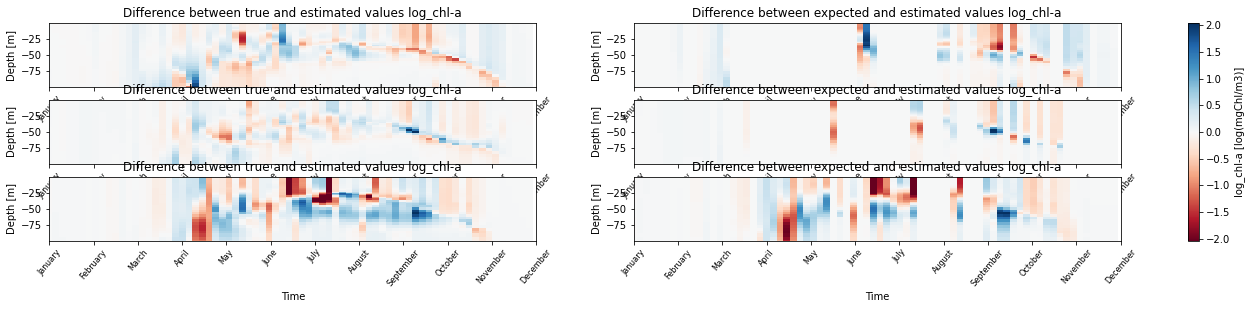

In [44]:
# Compute difference between true and estimated values, and also between expected values (the best we can retrieve)
# and estimated values.
difference = [values_true - values_estim, values_expec - values_estim]
labels= ["true and estimated values {}".format(prof_var[0]), "expected and estimated values {}".format(prof_var[0])]
fig=plt.figure(figsize=(24,4))

# Plot these differences.
for k in range(len(difference)):
    for y in range(nb_blocks):
        ax = fig.add_subplot(nb_blocks, 2, k+1+y*len(difference))
        print("ABSOLUTE ERROR MAX: ", np.max(np.abs(difference[k]))) 
        print("MEAN ABSOLUTE ERROR: ", np.mean(np.abs(difference[k])))
        zmax=np.max(difference[k][y*meas_per_block:(y+1)*meas_per_block,:])
        im=print_data_ax(ax,fig,difference[k][y*meas_per_block:(y+1)*meas_per_block,:],depth_levels,zmin=-zmax,zmax=zmax,
                   legend="Difference between {}".format(labels[k]), cmap='RdBu', label=prof_var[0], x_dates="months",sub_colorbar=False)
axes = np.array(fig.get_axes())
fig.colorbar(im,ax=axes,label=prof_var[0]+' ['+prof_units[0]+"]")
plt.savefig(fname = path_fig_saving+"Differences")

## 6.3) RMSE respect to depth

In [ ]:
# Compute RMSE respect to depth with true values as reference data.
rmse_true_esti = map_estimated.rmse_with_respect_to_depth(depth_levels)
rmse_true_esti.rename(columns = {prof_var[0]:prof_var[0]+'_ref_true'}, inplace = True)

# Compute RMSE respect to depth with expected values as reference data.
tmp_map = map2d.copy(map_estimated)
tmp_map.add_true_values(map_expected.values)
rmse_expect_esti = tmp_map.rmse_with_respect_to_depth(depth_levels)

# Add to the first dataset for convenient dataframe plot.
rmse_true_esti[prof_var[0]+'_ref_expected']=rmse_expect_esti[prof_var[0]]

# Plot RMSEs with respect to depth.
fig=plt.figure()
rmse_true_esti.plot(x="depth",y=[prof_var[0]+'_ref_true',prof_var[0]+'_ref_expected'])
plt.ylabel("RMSE over {} {}".format(prof_var[0],' ['+prof_units[0]+"]"))
plt.xlabel('Depth (m)')
plt.title('RMSE  of {} with respect to depth'.format(prof_var[0]))
plt.legend()
plt.savefig(fname = path_fig_saving+"RMSE_respect_to_depth")